# Circuit schematic creation and analysis

This example shows how to build a circuit schematic
and run a transient circuit simulation.

<img src="_static/circuit.png" width="600">

Keywords: **AEDT**, **Circuit**, **Schematic**.

## Import packages and define constants

Perform required imports.

In [1]:
import os
import tempfile
import time

import ansys.aedt.core
from ansys.aedt.core.generic.constants import Setups

Define constants.

In [2]:
AEDT_VERSION = "2025.2"
NG_MODE = False  # Open AEDT UI when it is launched.

## Create temporary directory

Create a temporary directory where downloaded data or
dumped data can be stored.
If you'd like to retrieve the project data for subsequent use,
the temporary folder name is given by ``temp_folder.name``.

In [3]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")

## Launch AEDT with Circuit

Launch AEDT with Circuit. The [pyaedt.Desktop](
https://aedt.docs.pyansys.com/version/stable/API/_autosummary/pyaedt.desktop.Desktop.html#pyaedt.desktop.Desktop)
class initializes AEDT and starts the specified version in the specified mode.

In [4]:

circuit = ansys.aedt.core.Circuit(
    project=os.path.join(temp_folder.name, "CircuitExample"),
    design="Simple",
    version=AEDT_VERSION,
    non_graphical=NG_MODE,
    new_desktop=True,
)

circuit.modeler.schematic.schematic_units = "mil"

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


PyAEDT INFO: PyAEDT version 0.25.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_bb6936c0-f1f9-417f-aac5-3ea467d7e6a6.log is enabled.


PyAEDT INFO: Log on AEDT is disabled.


PyAEDT INFO: Starting new AEDT gRPC session.


PyAEDT INFO: AEDT installation Path C:\Program Files\ANSYS Inc\v252\AnsysEM


PyAEDT INFO: Client application successfully started.


PyAEDT INFO: New AEDT gRPC session session started on port 50051.


PyAEDT INFO: 2025.2 version started with process ID 3216.


PyAEDT WARNING: Service Pack is not detected. PyAEDT is currently connecting in Insecure Mode.


PyAEDT WARNING: Please download and install latest Service Pack to use connect to AEDT in Secure Mode.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Project CircuitExample has been created.


PyAEDT INFO: Added design 'Simple' of type Circuit Design.


PyAEDT INFO: Aedt Objects correctly read


PyAEDT INFO: ModelerCircuit class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: ModelerNexxim class has been initialized!


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


## Create circuit setup

Create and customize a linear network analysis (LNA) setup.

In [5]:
setup1 = circuit.create_setup("MyLNA")
setup1.props["SweepDefinition"]["Data"] = "LINC 0GHz 4GHz 10001"

## Place components

Place components such as an inductor, resistor, and capacitor. The ``location`` argument
provides the ``[x, y]`` coordinates to place the component.

In [6]:
inductor = circuit.modeler.schematic.create_inductor(
    name="L1", value=1e-9, location=[0, 0]
)
resistor = circuit.modeler.schematic.create_resistor(
    name="R1", value=50, location=[500, 0]
)
capacitor = circuit.modeler.schematic.create_capacitor(
    name="C1", value=1e-12, location=[1000, 0]
)

## Get all pins

The component pins are instances of the
``ansys.aedt.core.modeler.circuits.objct3dcircuit.CircuitPins`` class and
provide access to the
pin location, net connectivity, and the ``connect_to_component()`` method, which
can be used to connect components in the schematic
as demonstrated in this example.

## Place a port and ground

Place a port and a ground in the schematic.

In [7]:
port = circuit.modeler.schematic.create_interface_port(
    name="myport", location=[-300, 50]
)
gnd = circuit.modeler.schematic.create_gnd(location=[1200, -100])

PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmpl8d8je64.ansys\CircuitExample.aedt.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmpl8d8je64.ansys\CircuitExample.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.015790462493896484


## Connect components

Connect components with wires in the schematic. The ``connect_to_component()``
method is used to create connections between pins.

In [8]:
port.pins[0].connect_to_component(assignment=inductor.pins[0], use_wire=True)
inductor.pins[1].connect_to_component(assignment=resistor.pins[1], use_wire=True)
resistor.pins[0].connect_to_component(assignment=capacitor.pins[0], use_wire=True)
capacitor.pins[1].connect_to_component(assignment=gnd.pins[0], use_wire=True)

True

## Create transient setup

Create a transient setup.

In [9]:
setup2 = circuit.create_setup(
    name="MyTransient", setup_type=Setups.NexximTransient
)
setup2.props["TransientData"] = ["0.01ns", "200ns"]
setup3 = circuit.create_setup(name="MyDC", setup_type=Setups.NexximDC)

## Solve transient setup

Solve the transient setup.

In [10]:
circuit.analyze_setup("MyLNA")
circuit.export_fullwave_spice()

PyAEDT INFO: Solving design setup MyLNA


PyAEDT INFO: Design setup MyLNA solved correctly in 0.0h 0.0m 11.0s


PyAEDT INFO: FullWaveSpice correctly exported to C:\Users\ansys\AppData\Local\Temp\tmpl8d8je64.ansys\CircuitExample.pyaedt\Simple\Simple.sp


WindowsPath('C:/Users/ansys/AppData/Local/Temp/tmpl8d8je64.ansys/CircuitExample.pyaedt/Simple/Simple.sp')

## Create report

Create a report displaying the scattering parameters.

In [11]:
solutions = circuit.post.get_solution_data(
    expressions=circuit.get_traces_for_plot(category="S"),
)
solutions.enable_pandas_output = True
real, imag = solutions.full_matrix_real_imag
print(real)

PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT WARNING: No report category provided. Automatically identified Standard


PyAEDT INFO: Solution Data Correctly Loaded.


Time to initialize solution data:0.015768051147460938
Time to initialize solution data:0.03143811225891113


{'S(myport,myport)': array([[0.00000000e+00, 1.00000000e+00],
       [4.00000000e-04, 9.99999937e-01],
       [8.00000000e-04, 9.99999747e-01],
       ...,
       [3.99920000e+00, 2.10646321e-02],
       [3.99960000e+00, 2.10463797e-02],
       [4.00000000e+00, 2.10281371e-02]], shape=(10001, 2))}


## Create plot

Create a plot based on solution data.

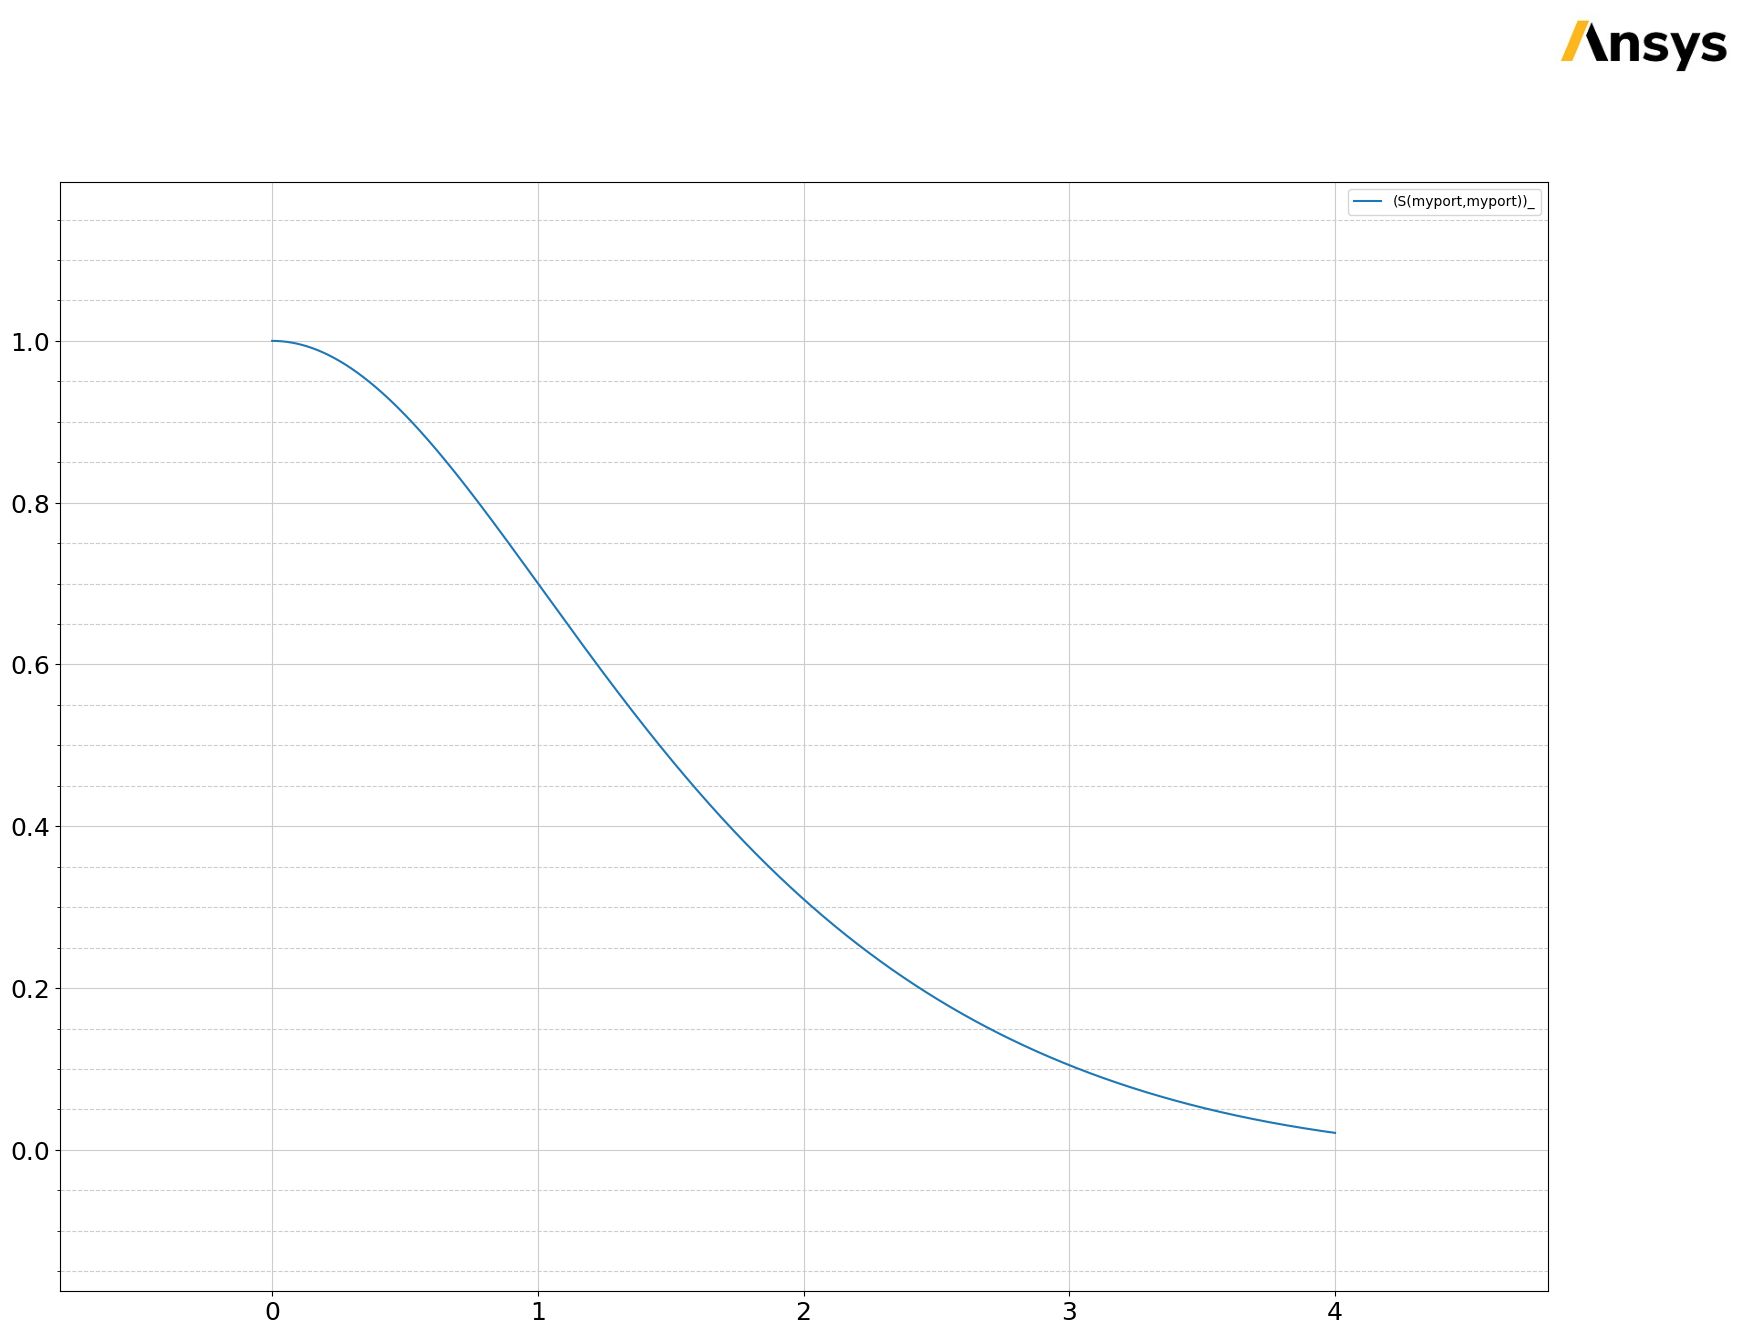

In [12]:
fig = solutions.plot()

## Release AEDT

Release AEDT and close the example.

In [13]:
circuit.save_project()
circuit.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project CircuitExample Saved correctly


PyAEDT INFO: Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_folder.name``. If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell removes all temporary files, including the project folder.

In [14]:
temp_folder.cleanup()